In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import yt

from galaxy_analysis.gizmo import yield_model

from galaxy_analysis.utilities import convert_abundances as ca
from galaxy_analysis.plot.plot_styles import *

In [4]:
#
# How to generate yields:
#
simulation = 'm12q'
wdir = "/home/aemerick/work/gizmo_runs/m12q_res5700_test/"

#simulation = 'm10q_fiducial_post'
#wdir = "/home/aemerick/work/gizmo_runs/m10q_test/full_fire_fiducial/"

age_bins = yield_model.get_bins(config_file = wdir + "/gizmo.out", binfile = wdir+"/age_bins.txt")


Z = 1.0E-5
FIRE_Z_scaling = True
age_is_fraction = True

total_yields = yield_model.construct_yields(age_bins/1000.0, # pass bins as Gyr, Z = Z,
                                    Z = Z, yieldtype = 'total', FIRE_Z_scaling=FIRE_Z_scaling)



# load ds and generate yields

N yield in SNII is less than zero due to FIRE scaling
N yield in SNIA is negative


In [5]:
ds0     = yt.load(wdir + 'output/snapshot_000.hdf5')
data0   = ds0.all_data()
fields = ds0.field_list

# generate
yield_model.generate_metal_fields(ds0,_agebins=age_bins,_yields=total_yields, age_is_fraction=age_is_fraction)
#yield_model._generate_star_metal_fields(ds0, _agebins = age_bins, _yields = total_yields)

metals = np.unique([x[1] for x in ds0.field_list if ((x[0] == 'PartType0') and ('Metal' in x[1]))])

initial_abundance=np.zeros(np.size(metals))
for i in np.arange(np.size(initial_abundance)):
    z = data0[('PartType0','Metallicity_%02i'%(i))]
    print("%5.5E %5.5E %5.5E"%(np.min(z),np.max(z),np.average(z)))

    initial_abundance[i] = np.average(z).value

2.00000E-06 2.00000E-06 2.00000E-06
2.50003E-01 2.50003E-01 2.50003E-01
3.26000E-07 3.26000E-07 3.26000E-07
1.32000E-07 1.32000E-07 1.32000E-07
8.65000E-07 8.65000E-07 8.65000E-07
2.22000E-07 2.22000E-07 2.22000E-07
9.31000E-08 9.31000E-08 9.31000E-08
1.08000E-07 1.08000E-07 1.08000E-07
6.44000E-08 6.44000E-08 6.44000E-08
1.01000E-08 1.01000E-08 1.01000E-08
1.73000E-07 1.73000E-07 1.73000E-07
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00

In [6]:
ds     = yt.load(wdir + 'output/snapshot_060.hdf5')
data   = ds.all_data()
fields = ds.field_list

# generate
yield_model.generate_metal_fields(ds,_agebins=age_bins,_yields=total_yields,age_is_fraction=age_is_fraction)
yield_model._generate_star_metal_fields(ds, _agebins = age_bins, _yields = total_yields,age_is_fraction=age_is_fraction)

ptypes = np.unique([x[0] for x in ds.field_list])
metals = np.unique([x[1] for x in ds.field_list if ((x[0] == 'PartType0') and ('Metal' in x[1]))])

print(np.min(data[('PartType0','particle_mass')].to('Msun')))
M_norm = np.min(data[('PartType0','particle_mass')].to('Msun') )


56538.21342723229 Msun


In [7]:
def _get_abund(e,dat,ptype='star'):
    
    if ptype == 'star':
        ptype = "PartType4"
    elif ptype == 'gas':
        ptype = "PartType0"
    
    
    
    if e == "H":
        return 1.0 - dat[(ptype,"Metallicity_00")] - dat[(ptype,"Metallicity_01")]
    else:
        ei = yield_model.elements.index(e)
        return data[(ptype,"Metallicity_%02i"%(ei))]
    
#
# Now plot for age tracers
#
def _get_age_abund(e,dat,ptype='star'):
    
    if ptype == 'star':
        ptype = "PartType4"
    elif ptype == 'gas':
        ptype = "PartType0"
    
    if e == "H":
        H_frac = 1.0 - dat[(ptype,"Metallicity_00")] - dat[(ptype,"Metallicity_01")]
        return H_frac
    else:
        ei = yield_model.elements.index(e)
        # very bad!!!
        mass = data[('all', ptype + '_' + e + '_mass')].to('Msun') 
        norm = data[(ptype,'particle_mass')].to('Msun')
       # M_norm # (16752.063237698454*yt.units.Msun)
        
        Z = mass / norm
        
        Z = Z + initial_abundance[yield_model.elements.index(e)]
        
        return Z# mass/norm #+ initial_abundance[yield_model.elements.index(e)]
        
def get_ratio(e1,e2,data,age=True):
    if age:
        vals1 = _get_age_abund(e1,data)
        vals2 = _get_age_abund(e2,data)
    else:
        vals1 = _get_abund(e1,data)
        vals2 = _get_abund(e2,data)
    return ca.abundance_ratio_array(e1,vals1,e2,vals2,
                                  input_type="abundance")    

-1.8475379983343 0.09320162218832029
-2.1370122499682855 1.7165987690761937


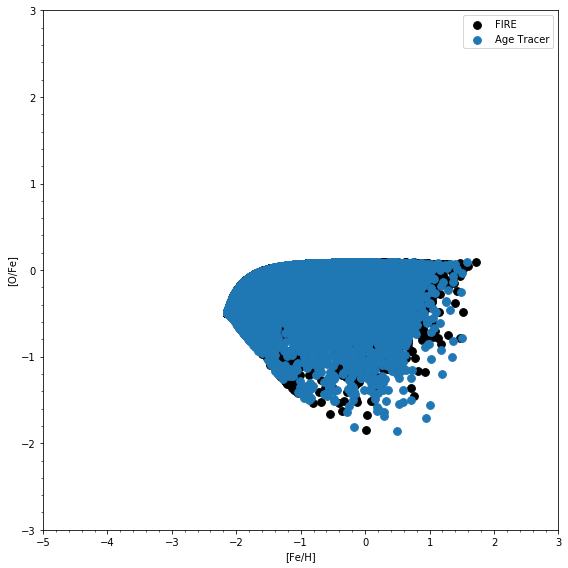

In [13]:
#
# Lets try and plot O / Fe vs Fe / H
#   for the fiducial fire stuff

# elements
y1e,y2e = "O", "Fe"
x1e,x2e = "Fe", "H"
#

#y1, y2 = yield_model.elements.index(y1e), yield_model.elements.index(y2e)
#x1, x2 = yield_model.elements.index(x1e), yield_model.elements.index(x2e)

    
y1_vals = _get_abund(y1e,data)
y2_vals = _get_abund(y2e,data)
y1y2    = ca.abundance_ratio_array(y1e, y1_vals, y2e, y2_vals,
                                  input_type="abundance")
x1_vals = _get_abund(x1e,data)
x2_vals = _get_abund(x2e,data)
x1x2    = ca.abundance_ratio_array(x1e, x1_vals, x2e, x2_vals,
                                   input_type = "abundance")

fig, ax = plt.subplots()
fig.set_size_inches(8,8)

ax.scatter(x1x2, y1y2, color = "black", s = 60, marker="o", label = "FIRE")
    
y1_vals = _get_age_abund(y1e,data)
y2_vals = _get_age_abund(y2e,data)
age_y1y2    = ca.abundance_ratio_array(y1e, y1_vals, y2e, y2_vals,
                                  input_type="abundance")
x1_vals = _get_age_abund(x1e,data)
x2_vals = _get_age_abund(x2e,data)
age_x1x2    = ca.abundance_ratio_array(x1e, x1_vals, x2e, x2_vals,
                                   input_type = "abundance")
print(np.min(y1y2),np.max(y1y2))
print(np.min(x1x2),np.max(x1x2))


ax.scatter(age_x1x2, age_y1y2, color = "C0", s = 60, marker="o", label = "Age Tracer")


ax.set_ylabel("[" + y1e + "/" + y2e + "]")
ax.set_xlabel("[" + x1e + "/" + x2e + "]")

ax.legend(loc='best')

ax.set_xlim(-5,3)
ax.set_ylim(-3,3)

plt.minorticks_on()
plt.tight_layout()

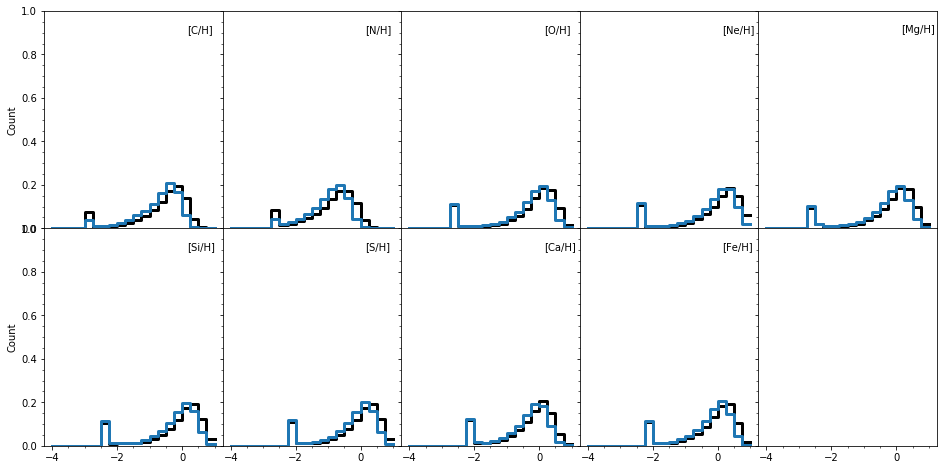

In [11]:
x1e = 'O'
x2e = 'H'

def MDF(x1e,x2e,data,rmin=None,rmax=None,dbin=0.25, age=True, ptype='star', diff = False):
    """
    Return MDF
    """
    
    
    if diff:
        x1_vals_age = _get_age_abund(x1e,data,ptype=ptype)
        x2_vals_age = _get_age_abund(x2e,data,ptype=ptype)        

        x1_vals = _get_abund(x1e,data,ptype=ptype)
        x2_vals = _get_abund(x2e,data,ptype=ptype)
        
        abund_age  = ca.abundance_ratio_array(x1e, x1_vals_age, x2e, x2_vals_age,
                                      input_type="abundance")
        abund  = ca.abundance_ratio_array(x1e, x1_vals, x2e, x2_vals,
                                      input_type="abundance")
        
        cutvals1 = _get_abund('O',data,ptype=ptype)
        cutvals2 = _get_abund('H',data,ptype=ptype)       
        
        H_cut = ca.abundance_ratio_array('O',cutvals1,'H',cutvals2,input_type='abundance')
        
        abund     = abund[ (H_cut > -2.6)]        
        abund_age = abund_age[ (H_cut > -2.6)]
        
        
        abund = abund - abund_age # diff 
        
    else:
        if age:
            x1_vals = _get_age_abund(x1e,data,ptype=ptype)
            x2_vals = _get_age_abund(x2e,data,ptype=ptype)
        else:
            x1_vals = _get_abund(x1e,data,ptype=ptype)
            x2_vals = _get_abund(x2e,data,ptype=ptype)
        
        abund  = ca.abundance_ratio_array(x1e, x1_vals, x2e, x2_vals,
                                      input_type="abundance")        
        if ptype == 'gas':
            cutvals1 = _get_abund('O',data,ptype=ptype)
            cutvals2 = _get_abund('H',data,ptype=ptype)       
        
            H_cut = ca.abundance_ratio_array('O',cutvals1,'H',cutvals2,input_type='abundance')
        
            abund     = abund[ (H_cut > -2.6)]        
            
        

    
    if rmin is None:
        rmin = np.min(abund)
    if rmax is None:
        rmax = np.max(abund)

    nbins = int((rmax - rmin)/dbin)
    
    hist, bins = np.histogram(abund, bins = nbins, range = (rmin,rmax))
    hist2 = np.ones(np.size(hist)+1)
    hist2[:-1] = hist
    hist2[-1] = hist2[-2]
    
    
    stats = {'median' : np.median(abund), 'mean' : np.average(abund),
             'IQR'    : np.quantile(abund,0.75) - np.quantile(abund,0.25),
             'std'    : np.std(abund)}
    
    if diff:
        return bins,hist2,stats
    else:
        return bins, hist2


fig,ax = plt.subplots(2,5,sharey=True,sharex=True)
fig.set_size_inches(16,8)
fig.subplots_adjust(wspace=0,hspace=0)



xy = (0.8,0.90)

#'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'S', 'Ca', 'Fe
bins,hist = MDF('C','H',data,-4,1,age=False)
ax[(0,0)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('C','H',data,-4,1,age=True)
ax[(0,0)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,0)].annotate('[C/H]',xy=xy,xycoords='axes fraction')


bins,hist = MDF('N','H',data,-4,1,age=False)
ax[(0,1)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('N','H',data,-4,1,age=True)
ax[(0,1)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,1)].annotate('[N/H]',xy=xy,xycoords='axes fraction')

bins,hist = MDF('O','H',data,-4,1,age=False)
ax[(0,2)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('O','H',data,-4,1,age=True)
ax[(0,2)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,2)].annotate('[O/H]',xy=xy,xycoords='axes fraction')


bins,hist = MDF('Ne','H',data,-4,1,age=False)
ax[(0,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('Ne','H',data,-4,1,age=True)
ax[(0,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,3)].annotate('[Ne/H]',xy=xy,xycoords='axes fraction')

bins,hist = MDF('Mg','H',data,-4,1,age=False)
ax[(0,4)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('Mg','H',data,-4,1,age=True)
ax[(0,4)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,4)].annotate('[Mg/H]',xy=xy,xycoords='axes fraction')

bins,hist = MDF('Si','H',data,-4,1,age=False)
ax[(1,0)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('Si','H',data,-4,1,age=True)
ax[(1,0)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(1,0)].annotate('[Si/H]',xy=xy,xycoords='axes fraction')

bins,hist = MDF('S','H',data,-4,1,age=False)
ax[(1,1)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('S','H',data,-4,1,age=True)
ax[(1,1)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(1,1)].annotate('[S/H]',xy=xy,xycoords='axes fraction')

bins,hist = MDF('Ca','H',data,-4,1,age=False)
ax[(1,2)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('Ca','H',data,-4,1,age=True)
ax[(1,2)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(1,2)].annotate('[Ca/H]',xy=xy,xycoords='axes fraction')

bins,hist = MDF('Fe','H',data,-4,1,age=False)
ax[(1,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('Fe','H',data,-4,1,age=True)
ax[(1,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(1,3)].annotate('[Fe/H]',xy=xy,xycoords='axes fraction')

for ax1 in ax:
    for ax2 in ax1:
        ax2.set_ylim(0,1)
ax[(0,0)].set_ylabel('Count')
ax[(1,0)].set_ylabel('Count')

plt.minorticks_on()


outname = simulation + '_stellar_MDFs.png'
fig.savefig(outname)

In [ ]:
#
# Lets try and plot O / Fe vs Fe / H
#   for the fiducial fire stuff

# elements
y1e,y2e = "O", "H"
x1e,x2e = "O","H"
#

#y1, y2 = yield_model.elements.index(y1e), yield_model.elements.index(y2e)
#x1, x2 = yield_model.elements.index(x1e), yield_model.elements.index(x2e)

    
y1_vals = _get_abund(y1e,data)
y2_vals = _get_abund(y2e,data)
y1y2    = ca.abundance_ratio_array(y1e, y1_vals, y2e, y2_vals,
                                  input_type="abundance")
x1_vals = _get_age_abund(x1e,data)
x2_vals = _get_age_abund(x2e,data)
x1x2    = ca.abundance_ratio_array(x1e, x1_vals, x2e, x2_vals,
                                   input_type = "abundance")

fig, ax = plt.subplots()
fig.set_size_inches(6,6)

ax.scatter(y1y2, y1y2-x1x2, color = "black", s = 60, marker="o", label = "FIRE")

ax.set_ylabel("FIRE - Age Tracer [" + y1e + "/" + y2e + "]")
ax.set_xlabel("FIRE[" + x1e + "/" + x2e + "]")

ax.legend(loc='best')

ax.set_xlim(-5,1)
#ax.set_ylim(ax.get_xlim())
ax.set_ylim(-2,2)
#ax.plot([-100,100],[-100,100])

plt.minorticks_on()
plt.tight_layout()

In [ ]:
y1y2

In [ ]:
pp = yt.PhasePlot(ds, 'PartType0_O_actual_mass', 'PartType0_O_mass', 
                 ('PartType0','particle_mass'), weight_field=None)
pp.set_xlim(1.0E-3,10.)
pp.set_ylim(1.0E-3,10.)

pp.set_log('PartType0_O_actual_mass',True)
pp.set_log('PartType0_O_mass',True)



x1e = 'O'
x2e = 'H'


amin,amax = -4,1


fig,ax = plt.subplots(2,5,sharey=True)
fig.set_size_inches(16,8)

fig.subplots_adjust(wspace=0)

#'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'S', 'Ca', 'Fe
bins,hist = MDF('C','H',data,amin,amax,age=False,ptype='gas')
ax[(0,0)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('C','H',data,amin,amax,age=True,ptype='gas')
ax[(0,0)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,0)].set_xlabel('[C/H]')


bins,hist = MDF('N','H',data,amin,amax,age=False,ptype='gas')
ax[(0,1)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('N','H',data,amin,amax,age=True,ptype='gas')
ax[(0,1)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,1)].set_xlabel('[N/H]')

bins,hist = MDF('O','H',data,amin,amax,age=False,ptype='gas')
ax[(0,2)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('O','H',data,amin,amax,age=True,ptype='gas')
ax[(0,2)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,2)].set_xlabel('[O/H]')


bins,hist = MDF('Ne','H',data,amin,amax,age=False,ptype='gas')
ax[(0,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('Ne','H',data,amin,amax,age=True,ptype='gas')
ax[(0,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,3)].set_xlabel('[Ne/H]')

bins,hist = MDF('Mg','H',data,amin,amax,age=False,ptype='gas')
ax[(0,4)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('Mg','H',data,amin,amax,age=True,ptype='gas')
ax[(0,4)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,4)].set_xlabel('[Mg/H]')

bins,hist = MDF('Si','H',data,amin,amax,age=False,ptype='gas')
ax[(1,0)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('Si','H',data,amin,amax,age=True,ptype='gas')
ax[(1,0)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(1,0)].set_xlabel('[Si/H]')

bins,hist = MDF('S','H',data,amin,amax,age=False,ptype='gas')
ax[(1,1)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('S','H',data,amin,amax,age=True,ptype='gas')
ax[(1,1)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(1,1)].set_xlabel('[S/H]')

bins,hist = MDF('Ca','H',data,amin,amax,age=False,ptype='gas')
ax[(1,2)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('Ca','H',data,amin,amax,age=True,ptype='gas')
ax[(1,2)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(1,2)].set_xlabel('[Si/H]')

bins,hist = MDF('Fe','H',data,amin,amax,age=False,ptype='gas')
ax[(1,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('Fe','H',data,amin,amax,age=True,ptype='gas')
ax[(1,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(1,3)].set_xlabel('[Fe/H]')


#bins,hist = MDF('O','Fe',data,-1,1,age=False,ptype='gas')
#ax[(1,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
#bins,hist = MDF('O','Fe',data,-1,1,age=True,ptype='gas')
#ax[(1,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
#ax[(1,3)].set_xlabel('[O/Fe]')

#bins,hist = MDF('N','O',data,-1,1,age=False,ptype='gas')
#ax[(1,4)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
#bins,hist = MDF('N','O',data,-1,1,age=True,ptype='gas')
#ax[(1,4)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
#ax[(1,4)].set_xlabel('[N/O]')

for ax1 in ax:
    for ax2 in ax1:
        ax2.set_ylim(0,1.0)
        ax2.set_xlim(-2.5,2.5)
        

outname = simulation + '_gas_MDFs.png'
fig.savefig(outname)        

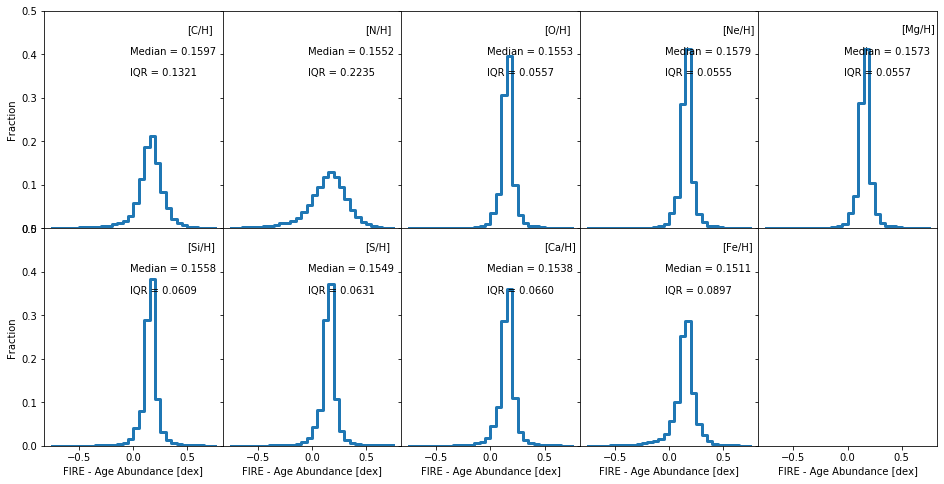

In [12]:
fig,ax = plt.subplots(2,5,sharey=True,sharex=True)
fig.set_size_inches(16,8)
fig.subplots_adjust(wspace=0,hspace=0)

amin,amax = -0.75, 0.75
dbin = 0.05

xy = (0.8,0.90)

bins,hist,stats = MDF('C','H',data,amin,amax,diff=True,dbin=dbin)
ax[(0,0)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,0)].annotate('[C/H]', xy=xy, xycoords = 'axes fraction')
ax[(0,0)].annotate('Median = %0.4f'%stats['median'], xy = (xy[0]-0.32,xy[1]-0.1), xycoords = 'axes fraction')
ax[(0,0)].annotate('IQR = %0.4f'%stats['IQR'], xy = (xy[0]-0.32,xy[1]-0.2), xycoords = 'axes fraction')

bins,hist,stats = MDF('N','H',data,amin,amax,diff=True,dbin=dbin)
ax[(0,1)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,1)].annotate('[N/H]', xy=xy, xycoords = 'axes fraction')
ax[(0,1)].annotate('Median = %0.4f'%stats['median'], xy = (xy[0]-0.32,xy[1]-0.1), xycoords = 'axes fraction')
ax[(0,1)].annotate('IQR = %0.4f'%stats['IQR'], xy = (xy[0]-0.32,xy[1]-0.2), xycoords = 'axes fraction')

bins,hist,stats = MDF('O','H',data,amin,amax,diff=True,dbin=dbin)
ax[(0,2)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,2)].annotate('[O/H]', xy=xy, xycoords = 'axes fraction')
ax[(0,2)].annotate('Median = %0.4f'%stats['median'], xy = (xy[0]-0.32,xy[1]-0.1), xycoords = 'axes fraction')
ax[(0,2)].annotate('IQR = %0.4f'%stats['IQR'], xy = (xy[0]-0.32,xy[1]-0.2), xycoords = 'axes fraction')

bins,hist,stats = MDF('Ne','H',data,amin,amax,diff=True,dbin=dbin)
ax[(0,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,3)].annotate('[Ne/H]', xy=xy, xycoords = 'axes fraction')
ax[(0,3)].annotate('Median = %0.4f'%stats['median'], xy = (xy[0]-0.32,xy[1]-0.1), xycoords = 'axes fraction')
ax[(0,3)].annotate('IQR = %0.4f'%stats['IQR'], xy = (xy[0]-0.32,xy[1]-0.2), xycoords = 'axes fraction')

bins,hist,stats = MDF('Mg','H',data,amin,amax,diff=True,dbin=dbin)
ax[(0,4)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,4)].annotate('[Mg/H]', xy=xy, xycoords = 'axes fraction')
ax[(0,4)].annotate('Median = %0.4f'%stats['median'], xy = (xy[0]-0.32,xy[1]-0.1), xycoords = 'axes fraction')
ax[(0,4)].annotate('IQR = %0.4f'%stats['IQR'], xy = (xy[0]-0.32,xy[1]-0.2), xycoords = 'axes fraction')

bins,hist,stats = MDF('Si','H',data,amin,amax,diff=True,dbin=dbin)
ax[(1,0)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(1,0)].annotate('[Si/H]', xy=xy, xycoords = 'axes fraction')
ax[(1,0)].annotate('Median = %0.4f'%stats['median'], xy = (xy[0]-0.32,xy[1]-0.1), xycoords = 'axes fraction')
ax[(1,0)].annotate('IQR = %0.4f'%stats['IQR'], xy = (xy[0]-0.32,xy[1]-0.2), xycoords = 'axes fraction')

bins,hist,stats = MDF('S','H',data,amin,amax,diff=True,dbin=dbin)
ax[(1,1)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(1,1)].annotate('[S/H]', xy=xy, xycoords = 'axes fraction')
ax[(1,1)].annotate('Median = %0.4f'%stats['median'], xy = (xy[0]-0.32,xy[1]-0.1), xycoords = 'axes fraction')
ax[(1,1)].annotate('IQR = %0.4f'%stats['IQR'], xy = (xy[0]-0.32,xy[1]-0.2), xycoords = 'axes fraction')

bins,hist,stats = MDF('Ca','H',data,amin,amax,diff=True,dbin=dbin)
ax[(1,2)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(1,2)].annotate('[Ca/H]', xy=xy, xycoords = 'axes fraction')
ax[(1,2)].annotate('Median = %0.4f'%stats['median'], xy = (xy[0]-0.32,xy[1]-0.1), xycoords = 'axes fraction')
ax[(1,2)].annotate('IQR = %0.4f'%stats['IQR'], xy = (xy[0]-0.32,xy[1]-0.2), xycoords = 'axes fraction')

bins,hist,stats = MDF('Fe','H',data,amin,amax,diff=True,dbin=dbin)
ax[(1,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(1,3)].annotate('[Fe/H]', xy=xy, xycoords = 'axes fraction')
ax[(1,3)].annotate('Median = %0.4f'%stats['median'], xy = (xy[0]-0.32,xy[1]-0.1), xycoords = 'axes fraction')
ax[(1,3)].annotate('IQR = %0.4f'%stats['IQR'], xy = (xy[0]-0.32,xy[1]-0.2), xycoords = 'axes fraction')

for ax1 in ax:
    for ax2 in ax1:
        ax2.set_ylim(0,0.5)
        
ax[(0,0)].set_ylabel('Fraction')
ax[(1,0)].set_ylabel('Fraction')

for i in np.arange(5):
    ax[(1,i)].set_xlabel('FIRE - Age Abundance [dex]')
    

outname = simulation + '_stellar_MDFs_offset.png'
fig.savefig(outname)    

In [ ]:
data[('PartType4','Metallicity_00')]

In [ ]:
np.sum(data[('all','PartType4_O_mass')])